**PREPARACIÓN DEL NOTEBOOK**

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
#!pip install kneed
from kneed import KneeLocator

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

## **NIVEL UNO**

In [73]:
df=pd.read_csv('https://raw.githubusercontent.com/JavierBurgos-web/PROYECTO_ANALITICA_2da_entrega/main/dataset_final.csv')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251 entries, 0 to 6250
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall        6251 non-null   int64  
 1   age            6251 non-null   int64  
 2   height_cm      6251 non-null   int64  
 3   weight_kg      6251 non-null   int64  
 4   club_position  6251 non-null   int64  
 5   pace           6251 non-null   float64
 6   shooting       6251 non-null   float64
 7   passing        6251 non-null   float64
 8   dribbling      6251 non-null   float64
 9   defending      6251 non-null   float64
 10  physic         6251 non-null   float64
 11  defending1     6251 non-null   float64
 12  attacking1     6251 non-null   float64
 13  skills1        6251 non-null   float64
 14  mentality1     6251 non-null   float64
 15  movement1      6251 non-null   float64
 16  power          6251 non-null   float64
dtypes: float64(12), int64(5)
memory usage: 830.3 KB


**DATASET ORIGINAL**

### **ALGORITMO K-MEANS**

In [75]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(df)
    inertia_list.append(kmeans.inertia_)

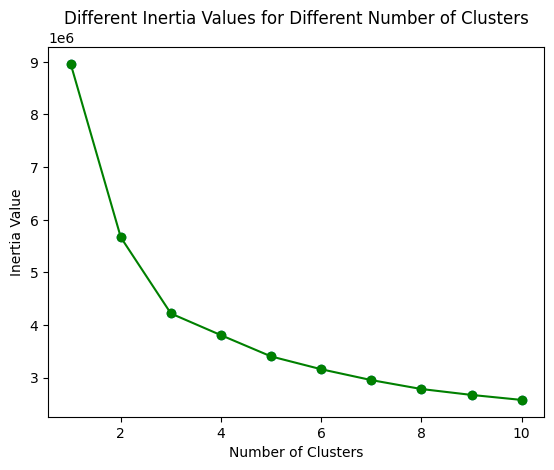

In [76]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list, color='green', marker='o')
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [77]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_1 = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl_1.elbow

3

In [78]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans.fit(df)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [79]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(df, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  4218161.141257677
Silhouette Score:  0.2952984873311604
Calinski harabasz score:  3511.4521799457143


**Lectura de anterior salida.**
- Se cuenta con una inercia alta
- Un indice de siluetas bajo, entre más cercano a 1 mejor. Este indice informa que tan bien esta echa la agrupación, quíza en este caso el dataset no sea tan suseptible a realizar agrupaciones.
- Indice de referencia de Calinski. Se usa para comparar con otro algoritmo.

In [80]:
## Para obtener la etiqueta que da el algoritmo
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(df)
Cluster_1

array([1, 2, 1, ..., 1, 0, 0])

In [81]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'df':
df_final = df.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1
0,83,32,177,77,3,80.0,82.0,78.0,84.0,31.0,67.0,22.333333,78.6,65.666667,69.000000,81.4,73.0,1
1,83,32,190,86,1,67.0,55.0,64.0,59.0,85.0,78.0,84.333333,59.8,52.500000,63.833333,64.6,69.4,2
2,83,35,193,80,3,66.0,83.0,72.0,78.0,45.0,76.0,32.666667,77.0,60.666667,70.833333,65.6,77.6,1
3,83,31,178,77,1,66.0,55.0,76.0,72.0,84.0,76.0,84.666667,66.6,58.833333,74.833333,71.6,71.6,2
4,83,32,183,80,0,72.0,81.0,77.0,81.0,80.0,85.0,78.000000,78.4,64.333333,79.666667,76.6,85.6,2


In [82]:
# NOTA: Se debe asignar una etiqueta a cada categoria de 'Cluster_1' para saber que nos esta informando
# Corroborar las etiquetas que se tiene
df_final.Cluster_1.unique()

array([1, 2, 0])

## **NIVEL DOS**

### **APLICACIÓN DE PCA**

In [83]:
#Cree un dataset reducido que proporcione el 85% de la varianza de entrada que debe explicarse
pca = PCA(n_components=0.85).fit(df)

#Veamos cuántas componentes ha conservado PCA:
pca.n_components_

3

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise 

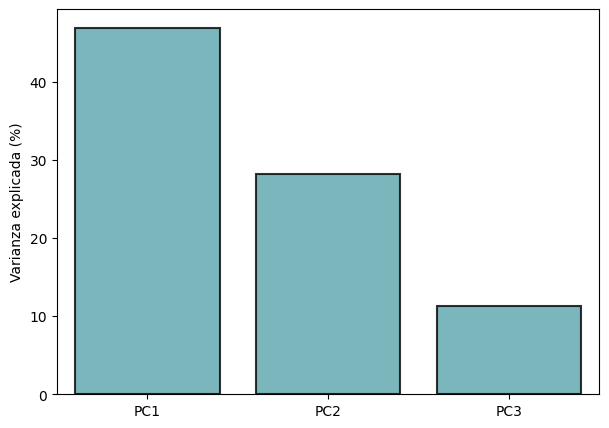

In [84]:
## Diagrama la varianza explicada para cada una de los 5 componentes
## Con este grafico se evalua como las componentes estan explicando las varianzas

# --- Varianza explicada --- 
PCA_variance_1 = pd.DataFrame({'Varianza explicada (%)':
                             pca.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC' + str(i) for i in range(1, 4)],
                  y = PCA_variance_1['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.8)

plt.show()

In [85]:
# Porsentaje de varianza explicada por cada componente
PCA_variance_1

,Varianza explicada (%)
0,46.944411
1,28.196402
2,11.362331


**Lectura del anterior gráfico y tabla.** 
El conjunto de datos original tenía 17 columnas que representaban diferentes características, como la puntuación general de los jugadores, su edad, altura, peso, estadísticas de juego, habilidades, etc.

La reducción de dimensionalidad se realizó utilizando PCA con el objetivo de conservar el 85% de la varianza de los datos originales. Esto significa que el nuevo conjunto de datos reducido aún explica la mayor parte de la variabilidad en los datos originales, pero con muchas menos dimensiones.

Después de aplicar PCA, se determinó que solo se necesitaban 3 componentes principales para conservar el 85% de la varianza de los datos. Esto significa que estas tres combinaciones lineales de características originales son las más informativas y explican la mayor parte de la variabilidad en los datos.

Este resultado permite trabajar con un conjunto de datos mucho más compacto, lo que puede facilitar el análisis, la visualización y la modelización, al tiempo que se conserva la información esencial contenida en el conjunto de datos original

In [86]:
#Por último, transforme "df" de 18 columnas X_pca
X_pca_1 = pca.fit_transform(df)
X_pca_1 #Dataset ya transformado

array([[ 60.8857691 ,  22.82989908,   4.62140937],
       [-35.54346435,  27.72357142,  11.20448388],
       [ 38.26089617,  24.18796071,  28.47184666],
       ...,
       [ 27.25048357, -57.80413408, -15.01742252],
       [ -0.91055596, -41.95233297,   1.42387317],
       [-13.91121805, -47.10303842,   5.55913758]])

**ANÁLISIS DE LAS VARIABLES POR CADA COMPONENTE**

In [87]:
# df_final sevirá para analizar el resultado
df_final['PCA1'] = X_pca_1[:,0]
df_final['PCA2'] = X_pca_1[:,1]
df_final['PCA3'] = X_pca_1[:,2]
df_final.head(3)

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,...,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1,PCA1,PCA2,PCA3
0,83,32,177,77,3,80.0,82.0,78.0,84.0,31.0,...,22.333333,78.6,65.666667,69.000000,81.4,73.0,1,60.885769,22.829899,4.621409
1,83,32,190,86,1,67.0,55.0,64.0,59.0,85.0,...,84.333333,59.8,52.500000,63.833333,64.6,69.4,2,-35.543464,27.723571,11.204484
2,83,35,193,80,3,66.0,83.0,72.0,78.0,45.0,...,32.666667,77.0,60.666667,70.833333,65.6,77.6,1,38.260896,24.187961,28.471847


In [88]:
# --- Pesos de las variables que componen las componentes principales ---
pesos_pca = pd.DataFrame(pca.components_, columns = df.columns,
             index = ['PC 1', 'PC 2', 'PC 3']).round(2).T

pesos_pca

,PC 1,PC 2,PC 3
overall,0.02,0.20,0.05
age,-0.00,0.05,0.11
height_cm,-0.07,-0.06,0.32
weight_kg,-0.05,-0.04,0.34
club_position,0.02,-0.02,0.02
pace,0.18,0.08,-0.54
shooting,0.42,0.34,0.25
passing,0.10,0.37,-0.05
dribbling,0.18,0.28,-0.13
defending,-0.53,0.34,-0.06


**Lectura para tabla anterior** Aporte de cada variable a cada uno de los tres componentes

### **ALGORITMO K-MEANS**

In [89]:
# Número optimo de K
inertia_list_1 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(X_pca_1)
    inertia_list_1.append(kmeans.inertia_)

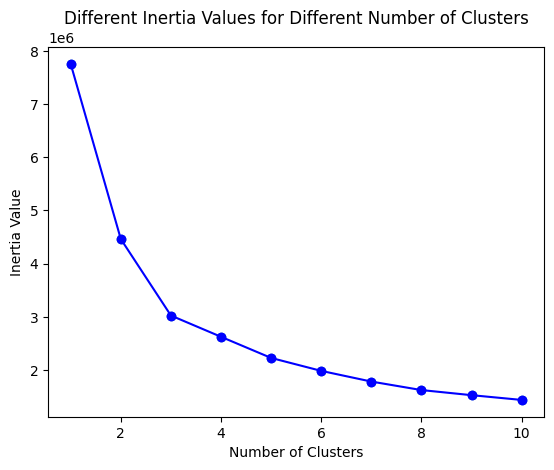

In [90]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list_1, color='blue', marker='o')
plt.scatter(range(1,11),inertia_list_1)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [91]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_1 = KneeLocator(range(1, 11),
                 inertia_list_1, curve="convex",
                 direction="decreasing")
kl_1.elbow

3

In [92]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans.fit(X_pca_1)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [93]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca_1, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca_1, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  3023652.2984972713
Silhouette Score:  0.36524639699250255
Calinski harabasz score:  4883.444567366748


**Lectura de anterior salida.**
- Se cuenta con una inercia alta
- Un indice de siluetas bajo, entre más cercano a 1 mejor. Este indice informa que tan bien esta echa la agrupación, quíza en este caso el dataset no sea tan suseptible a realizar agrupaciones.
- Indice de referencia de Calinski. Se usa para comparar con otro algoritmo.

**CONCLUSIÓN HASTA EL MOMENTO** 

El algoritmo de kmeans si esta haciendo una buena agrupación, esto se debe quiza a la información del dataset

In [94]:
## Para obtener la etiqueta que da el algoritmo
# Predicción de los clusters
Cluster_2 = model_kmeans.fit_predict(df)
Cluster_2

array([1, 2, 1, ..., 1, 0, 0])

In [95]:
# Vamos a adjuntar 'Cluster_2' como una nueva variable a 'df':
df_final['Cluster_2'] = Cluster_2

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,...,attacking1,skills1,mentality1,movement1,power,Cluster_1,PCA1,PCA2,PCA3,Cluster_2
0,83,32,177,77,3,80.0,82.0,78.0,84.0,31.0,...,78.6,65.666667,69.000000,81.4,73.0,1,60.885769,22.829899,4.621409,1
1,83,32,190,86,1,67.0,55.0,64.0,59.0,85.0,...,59.8,52.500000,63.833333,64.6,69.4,2,-35.543464,27.723571,11.204484,2
2,83,35,193,80,3,66.0,83.0,72.0,78.0,45.0,...,77.0,60.666667,70.833333,65.6,77.6,1,38.260896,24.187961,28.471847,1
3,83,31,178,77,1,66.0,55.0,76.0,72.0,84.0,...,66.6,58.833333,74.833333,71.6,71.6,2,-26.288109,45.156560,1.498547,2
4,83,32,183,80,0,72.0,81.0,77.0,81.0,80.0,...,78.4,64.333333,79.666667,76.6,85.6,2,-2.616748,64.646531,13.642067,2


In [96]:
# NOTA: Se debe asignar una etiqueta a cada categoria de 'Cluster_2' para saber que nos esta informando
# Corroborar las etiquetas que se tiene
df_final.Cluster_2.unique()

array([1, 2, 0])

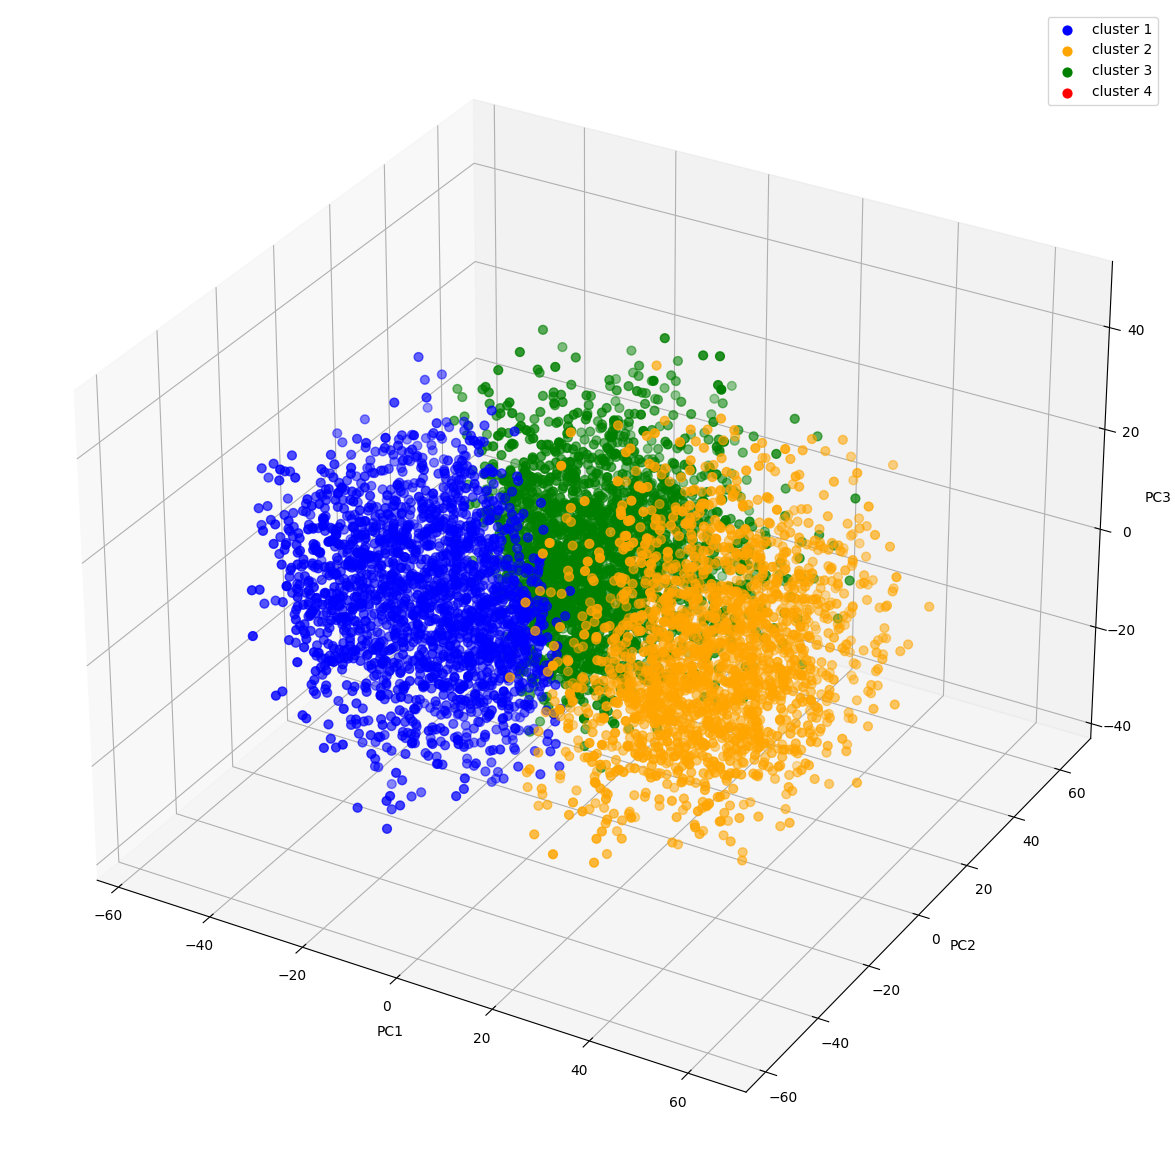

In [97]:
### Gráfico de dispersión respecto al 'cluster_2'
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_1[Cluster_2 == 0,0],X_pca_1[Cluster_2 == 0,1],X_pca_1[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca_1[Cluster_2 == 1,0],X_pca_1[Cluster_2 == 1,1],X_pca_1[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 2")
ax.scatter(X_pca_1[Cluster_2 == 2,0],X_pca_1[Cluster_2 == 2,1],X_pca_1[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(X_pca_1[Cluster_2 == 3,0],X_pca_1[Cluster_2 == 3,1],X_pca_1[Cluster_2 == 3,2], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

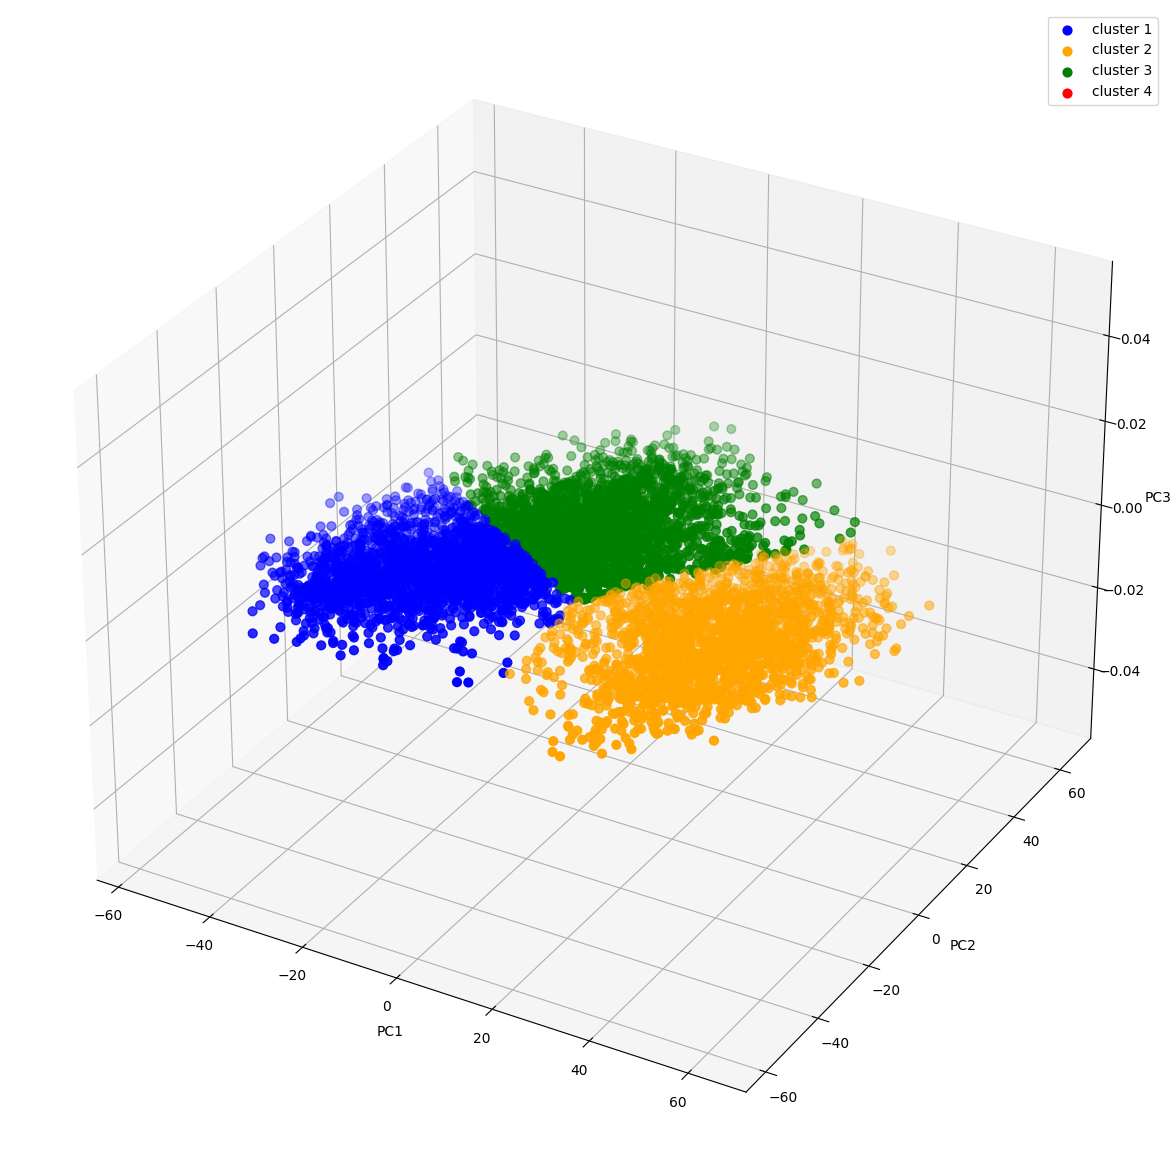

In [98]:
### Gráfico de dispersión respecto al 'cluster_2'
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_1[Cluster_2 == 0,0],X_pca_1[Cluster_2 == 0,1], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca_1[Cluster_2 == 1,0],X_pca_1[Cluster_2 == 1,1], s = 40 , color = 'orange', label = "cluster 2")
ax.scatter(X_pca_1[Cluster_2 == 2,0],X_pca_1[Cluster_2 == 2,1], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(X_pca_1[Cluster_2 == 3,0],X_pca_1[Cluster_2 == 3,1], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## **NIVEL TRES**

### **ALGORITMO GaussianMixture**

Text(0.5, 0, 'Número de Clusters')

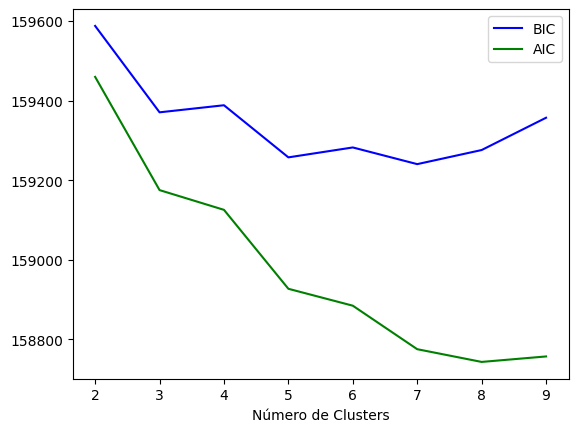

In [99]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 10)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(X_pca_1) for n in n_components]

plt.plot(n_components, [m.bic(X_pca_1) for m in models_g], label="BIC", color="blue")
plt.plot(n_components, [m.aic(X_pca_1) for m in models_g], label="AIC", color="green")
plt.legend()
plt.xlabel("Número de Clusters")

In [100]:
# --- Modelo GMM ---
model_gmm = GaussianMixture(n_components=3, random_state=123, covariance_type = 'full').fit(X_pca_1)

In [101]:

# --- Evaluación del modelo GMM ---
labels_ = model_gmm.predict(X_pca_1)

print(" ### GaussianMixture ###")
print('Silhouette Score: ', silhouette_score(X_pca_1, labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca_1, labels_))

 ### GaussianMixture ###
Silhouette Score:  0.3552561376002395
Calinski harabasz score:  4706.089041865195


In [102]:
# Predicción de los clusters
Cluster_3 = model_gmm.fit_predict(X_pca_1)

df_final['Cluster_3']= Cluster_3

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,...,skills1,mentality1,movement1,power,Cluster_1,PCA1,PCA2,PCA3,Cluster_2,Cluster_3
0,83,32,177,77,3,80.0,82.0,78.0,84.0,31.0,...,65.666667,69.000000,81.4,73.0,1,60.885769,22.829899,4.621409,1,1
1,83,32,190,86,1,67.0,55.0,64.0,59.0,85.0,...,52.500000,63.833333,64.6,69.4,2,-35.543464,27.723571,11.204484,2,2
2,83,35,193,80,3,66.0,83.0,72.0,78.0,45.0,...,60.666667,70.833333,65.6,77.6,1,38.260896,24.187961,28.471847,1,1


In [103]:
df_final['Cluster_3'].value_counts()

Cluster_3
2    2492
1    1927
0    1832
Name: count, dtype: int64

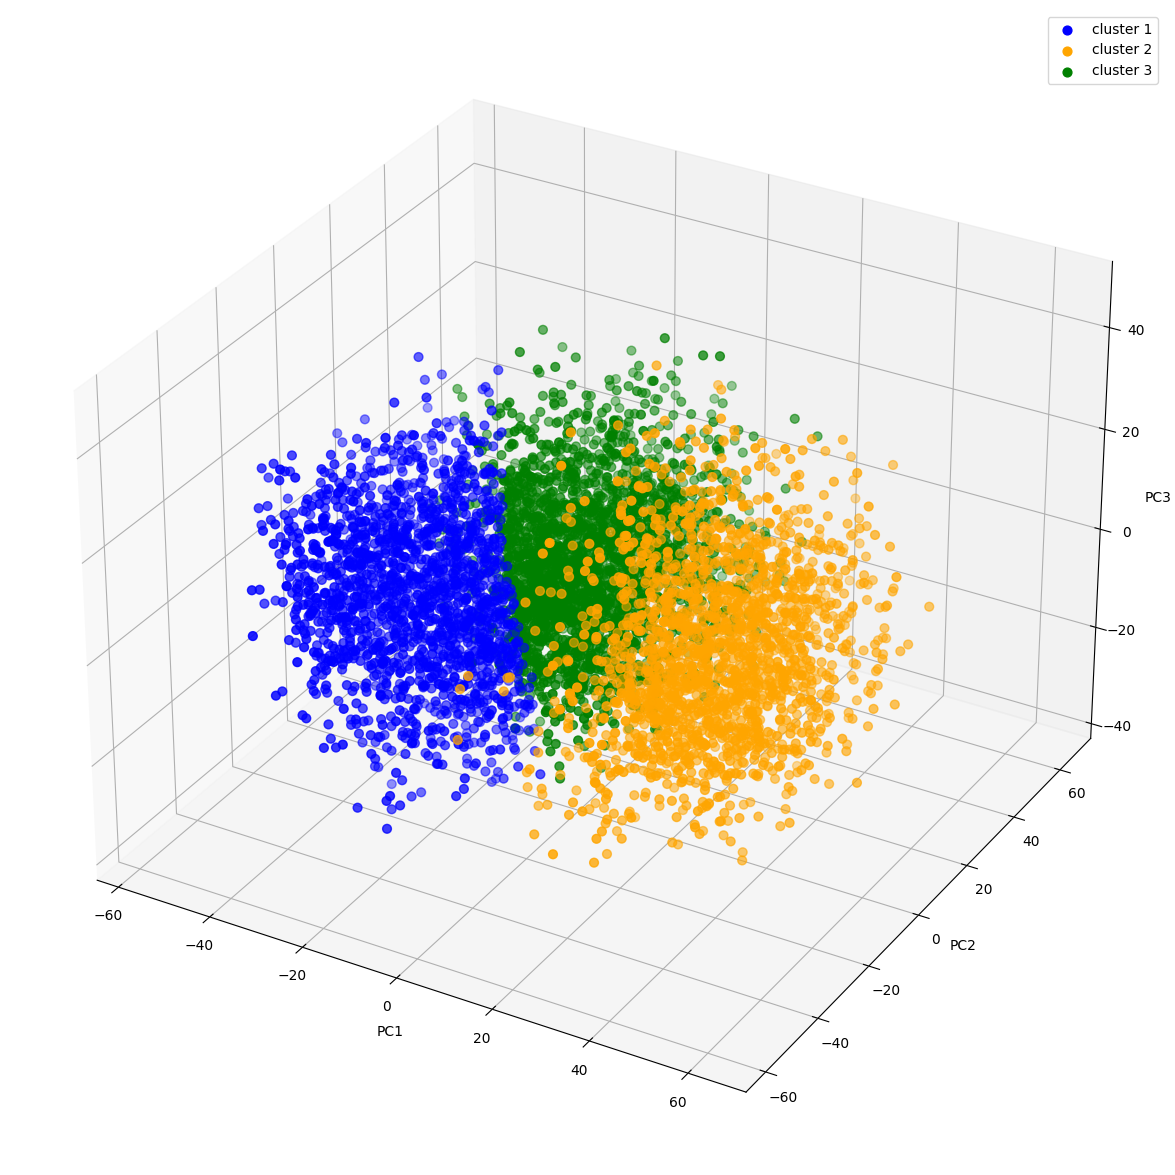

In [121]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_1[Cluster_3 == 0,0],X_pca_1[Cluster_3 == 0,1],X_pca_1[Cluster_3 == 0,2], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca_1[Cluster_3 == 1,0],X_pca_1[Cluster_3 == 1,1],X_pca_1[Cluster_3 == 1,2], s = 40 , color = 'orange', label = "cluster 2")
ax.scatter(X_pca_1[Cluster_3 == 2,0],X_pca_1[Cluster_3 == 2,1],X_pca_1[Cluster_3 == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

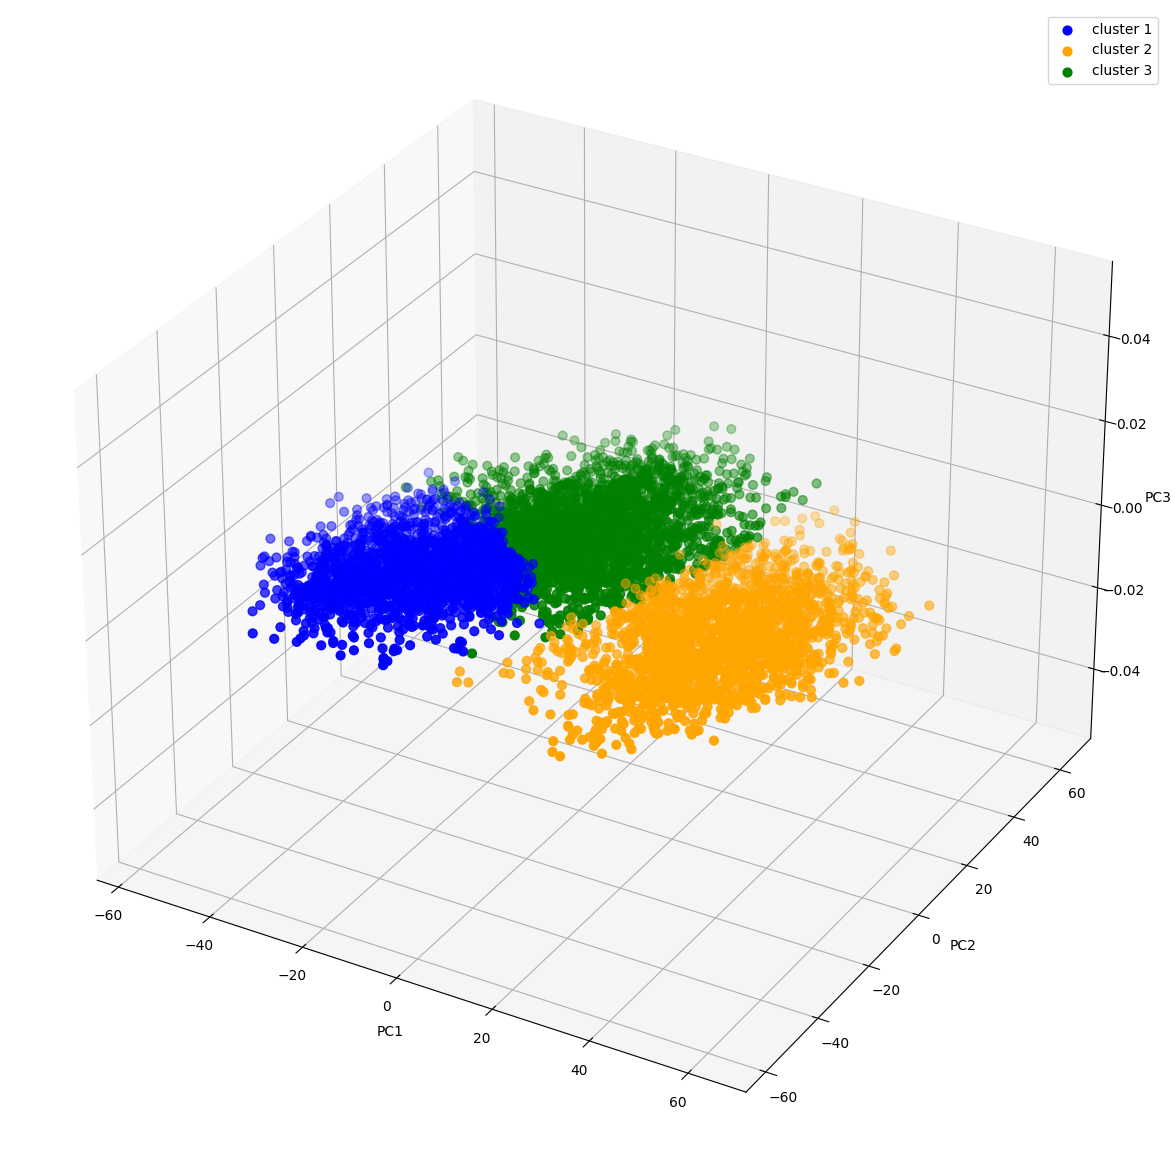

In [122]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_1[Cluster_3 == 0,0],X_pca_1[Cluster_3 == 0,1], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca_1[Cluster_3 == 1,0],X_pca_1[Cluster_3 == 1,1], s = 40 , color = 'orange', label = "cluster 2")
ax.scatter(X_pca_1[Cluster_3 == 2,0],X_pca_1[Cluster_3 == 2,1], s = 40 , color = 'green', label = "cluster 3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## **INTERPRESTACIÓN DE LOS CLUSTERS**

**CLUSTER 1**

In [123]:
df_final.head()

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,...,skills1,mentality1,movement1,power,Cluster_1,PCA1,PCA2,PCA3,Cluster_2,Cluster_3
0,83,32,177,77,3,80.0,82.0,78.0,84.0,31.0,...,65.666667,69.000000,81.4,73.0,1,60.885769,22.829899,4.621409,1,1
1,83,32,190,86,1,67.0,55.0,64.0,59.0,85.0,...,52.500000,63.833333,64.6,69.4,2,-35.543464,27.723571,11.204484,2,2
2,83,35,193,80,3,66.0,83.0,72.0,78.0,45.0,...,60.666667,70.833333,65.6,77.6,1,38.260896,24.187961,28.471847,1,1
3,83,31,178,77,1,66.0,55.0,76.0,72.0,84.0,...,58.833333,74.833333,71.6,71.6,2,-26.288109,45.156560,1.498547,2,2
4,83,32,183,80,0,72.0,81.0,77.0,81.0,80.0,...,64.333333,79.666667,76.6,85.6,2,-2.616748,64.646531,13.642067,2,2


C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Cluster_1', ylabel='count'>

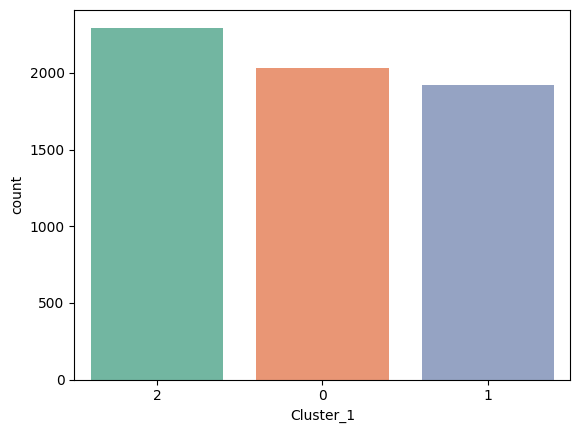

In [107]:
# Composición de los clusters formados
sns.countplot(x="Cluster_1",data=df_final, palette="Set2", order = df_final['Cluster_1'].value_counts().index)

In [125]:
# Composición de los clusters - Media de las variables por cluster
df_final.groupby(['Cluster_1']).mean()

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,...,attacking1,skills1,mentality1,movement1,power,PCA1,PCA2,PCA3,Cluster_2,Cluster_3
Cluster_1,,,,,,,,,,,,,,,,,,,,,
0,66.059577,25.819301,182.936484,76.454948,0.807976,64.951256,39.205318,53.366322,57.232890,63.966519,...,47.964549,41.542918,53.417939,62.730773,59.835844,-24.924651,-13.242412,-0.644058,0.0,0.207287
1,68.792100,26.340437,179.657484,74.107588,1.799376,74.338877,66.010915,60.781185,68.987006,34.802495,...,61.487006,51.448631,57.160256,71.351143,66.631705,32.966095,-8.316431,1.967635,1.0,1.028067
2,71.030052,27.128920,179.032230,73.349303,0.468206,70.345383,59.613676,66.776568,69.369774,64.933798,...,60.348519,54.470311,64.365055,70.435017,68.643990,-5.577004,18.682993,-1.079115,2.0,1.965157


C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

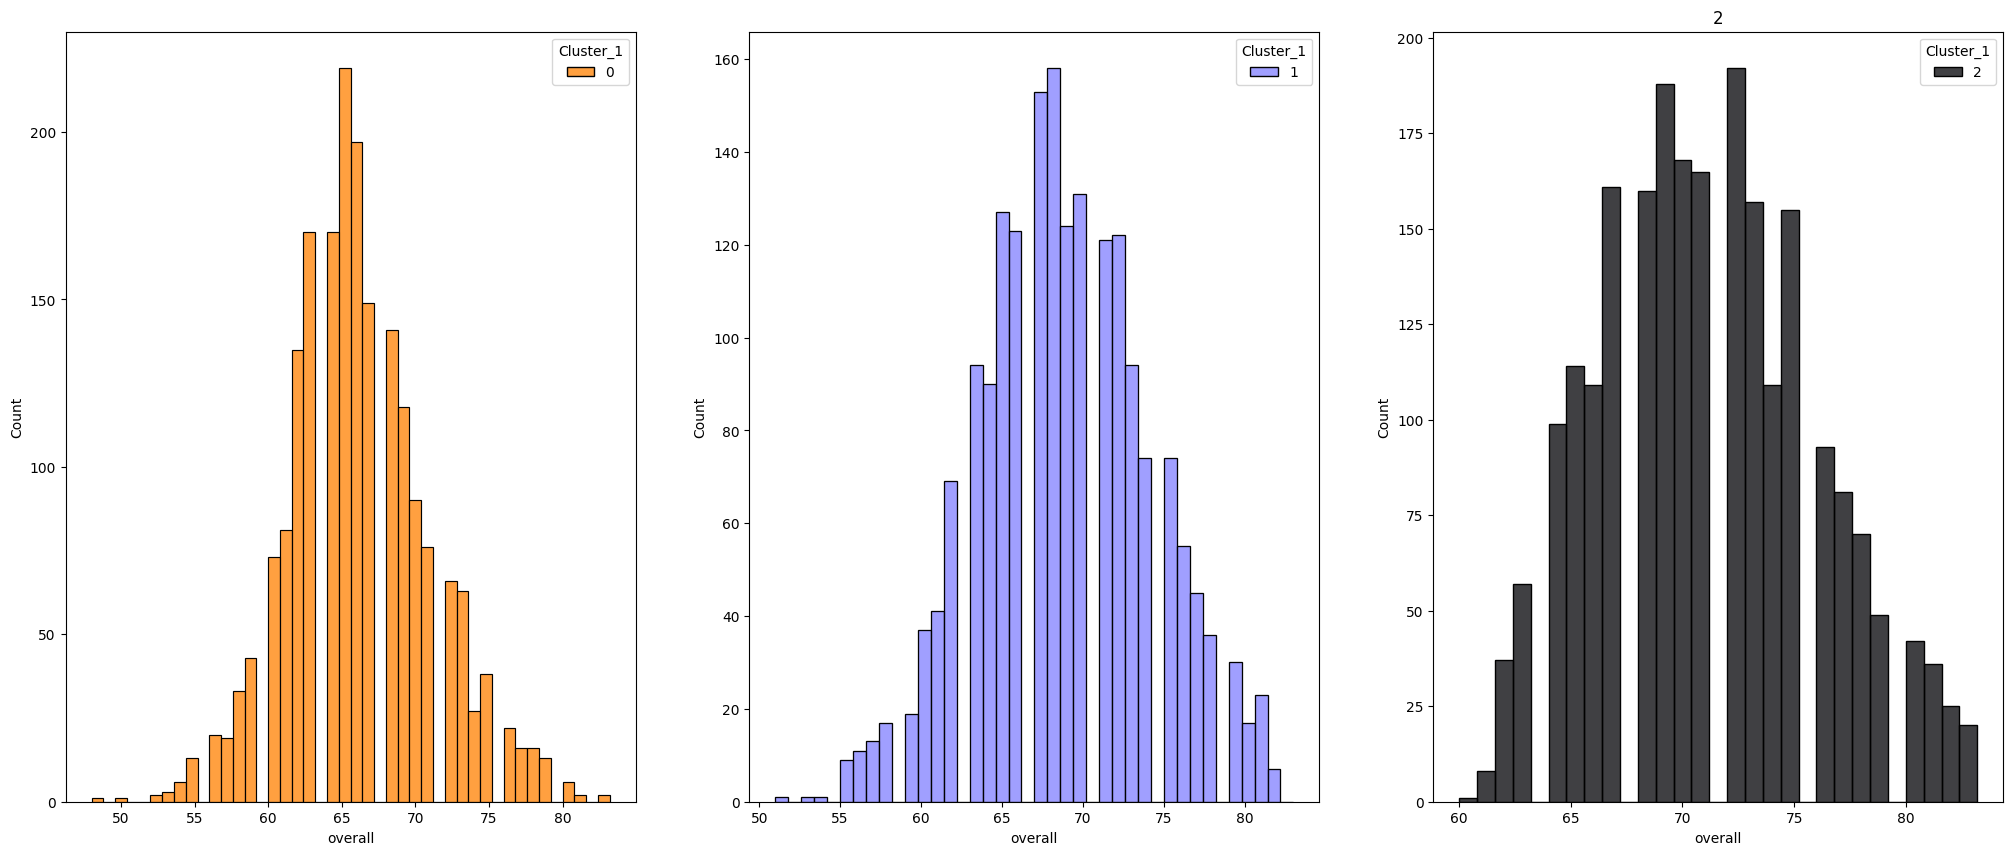

In [128]:
pal=['autumn','cool','magma','spring','winter'] # 5 color palettes for 5 categorical vars

# Análisis de la overall
temp_edad = df_final[['Cluster_1','overall']]
fig,axs=plt.subplots(ncols=3,figsize =(25, 10))

for i in list(range(0,3)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='overall',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

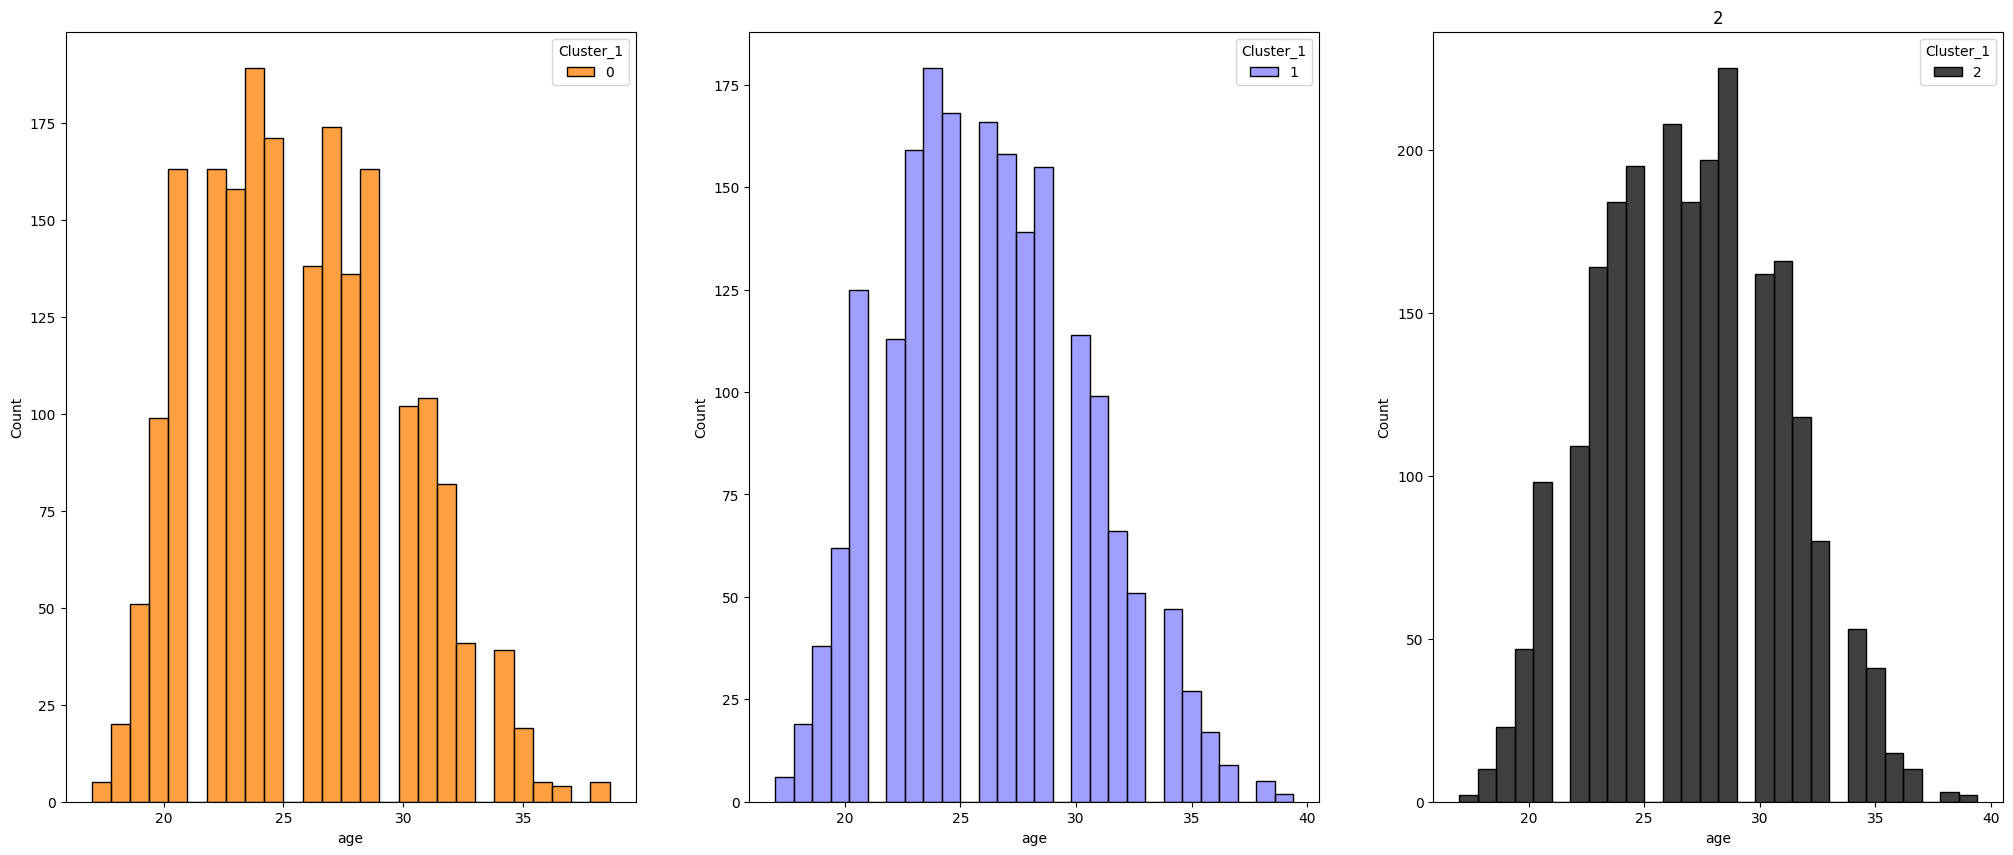

In [129]:
# Análisis de la age
temp_edad = df_final[['Cluster_1','age']]
fig,axs=plt.subplots(ncols=3,figsize =(25, 10))

for i in list(range(0,3)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='age',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

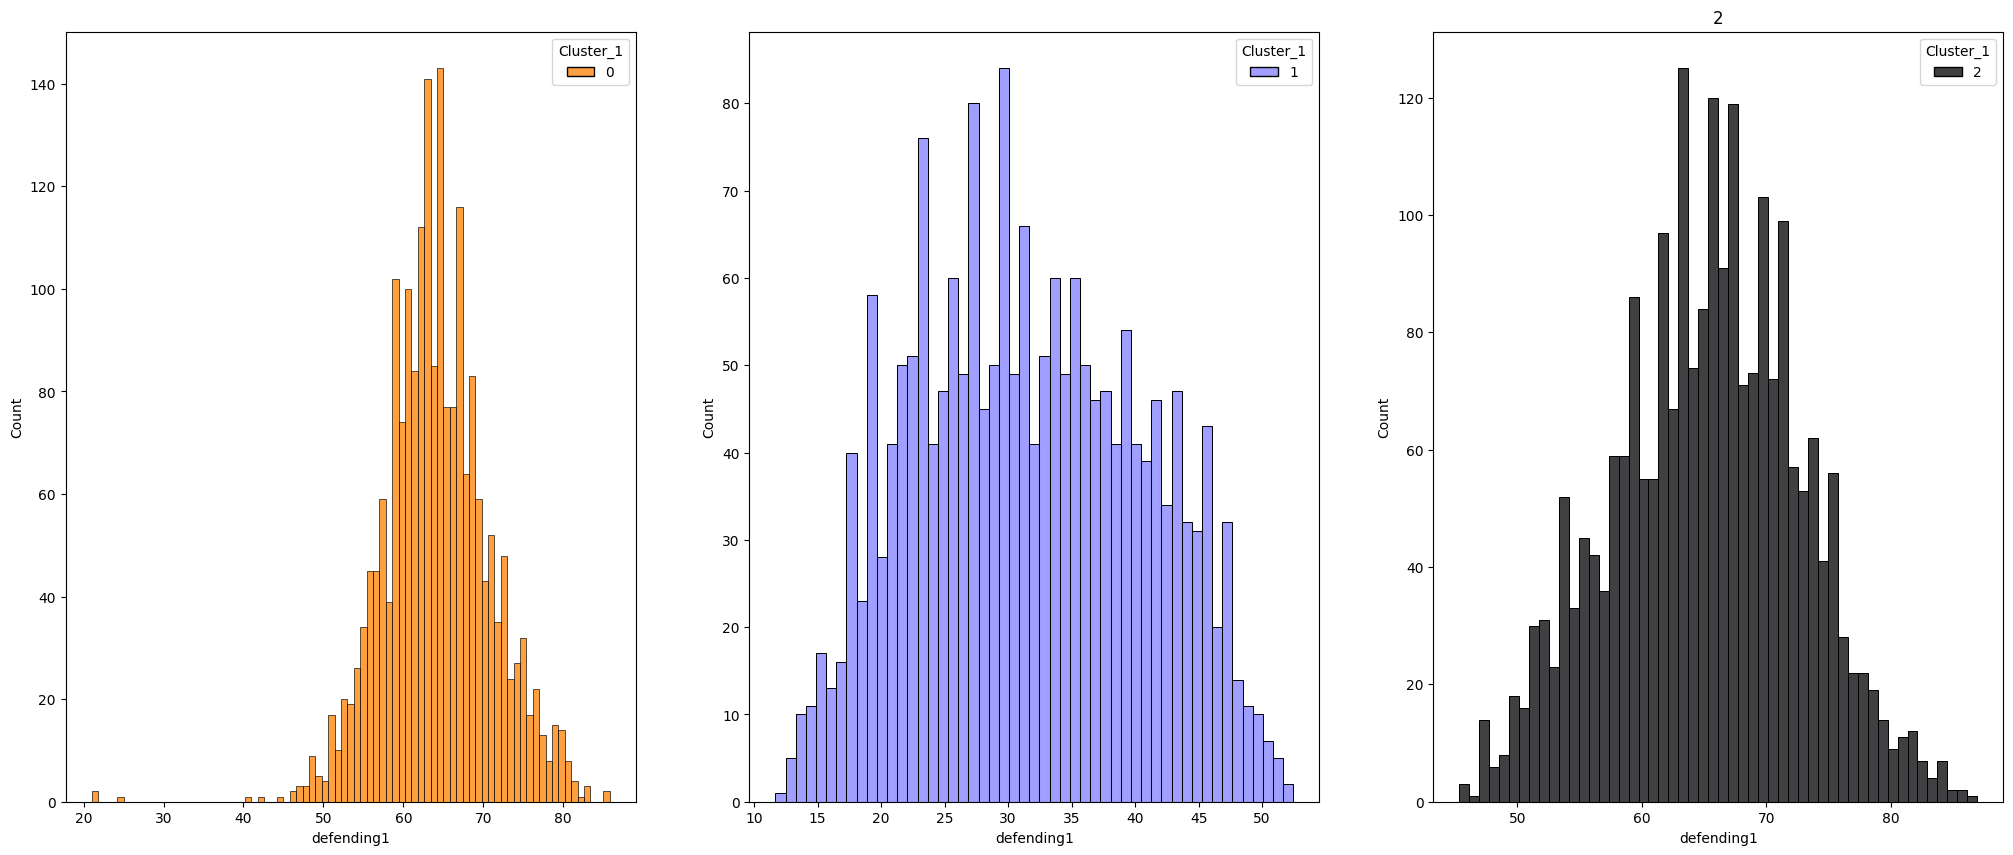

In [130]:
# Análisis de la defending1
temp_edad = df_final[['Cluster_1','defending1']]
fig,axs=plt.subplots(ncols=3,figsize =(25, 10))

for i in list(range(0,3)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='defending1',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

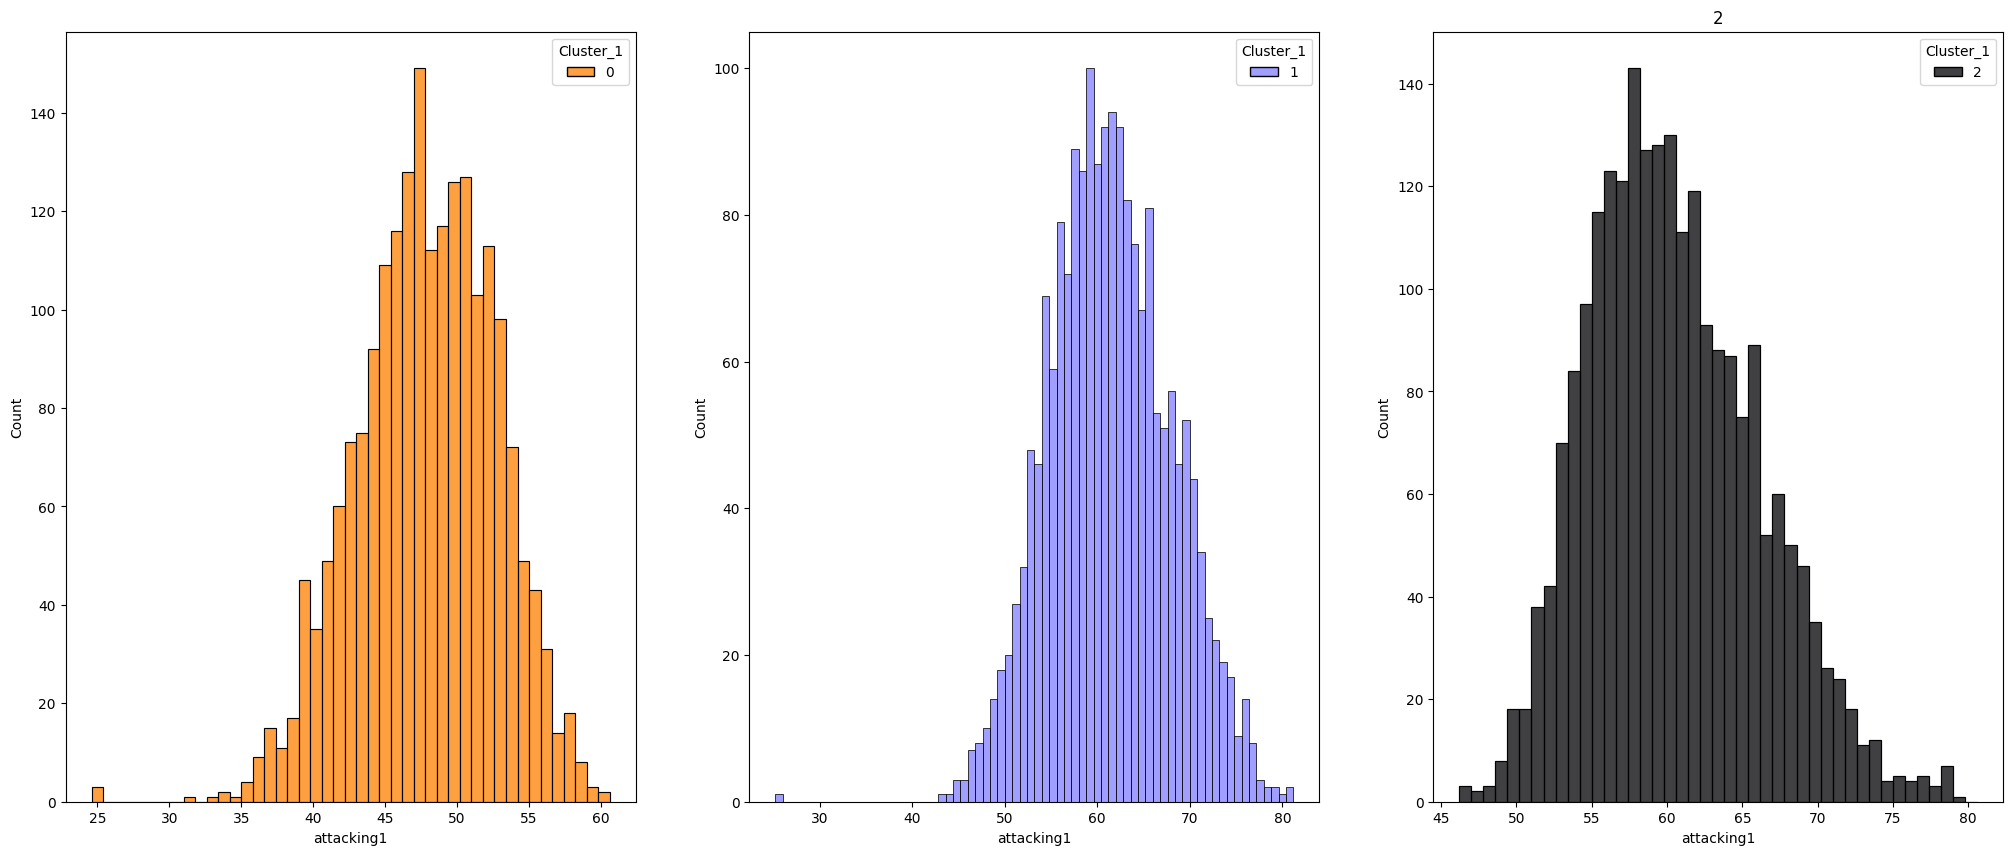

In [131]:
# Análisis de la attacking1
temp_edad = df_final[['Cluster_1','attacking1']]
fig,axs=plt.subplots(ncols=3,figsize =(25, 10))

for i in list(range(0,3)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='attacking1',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

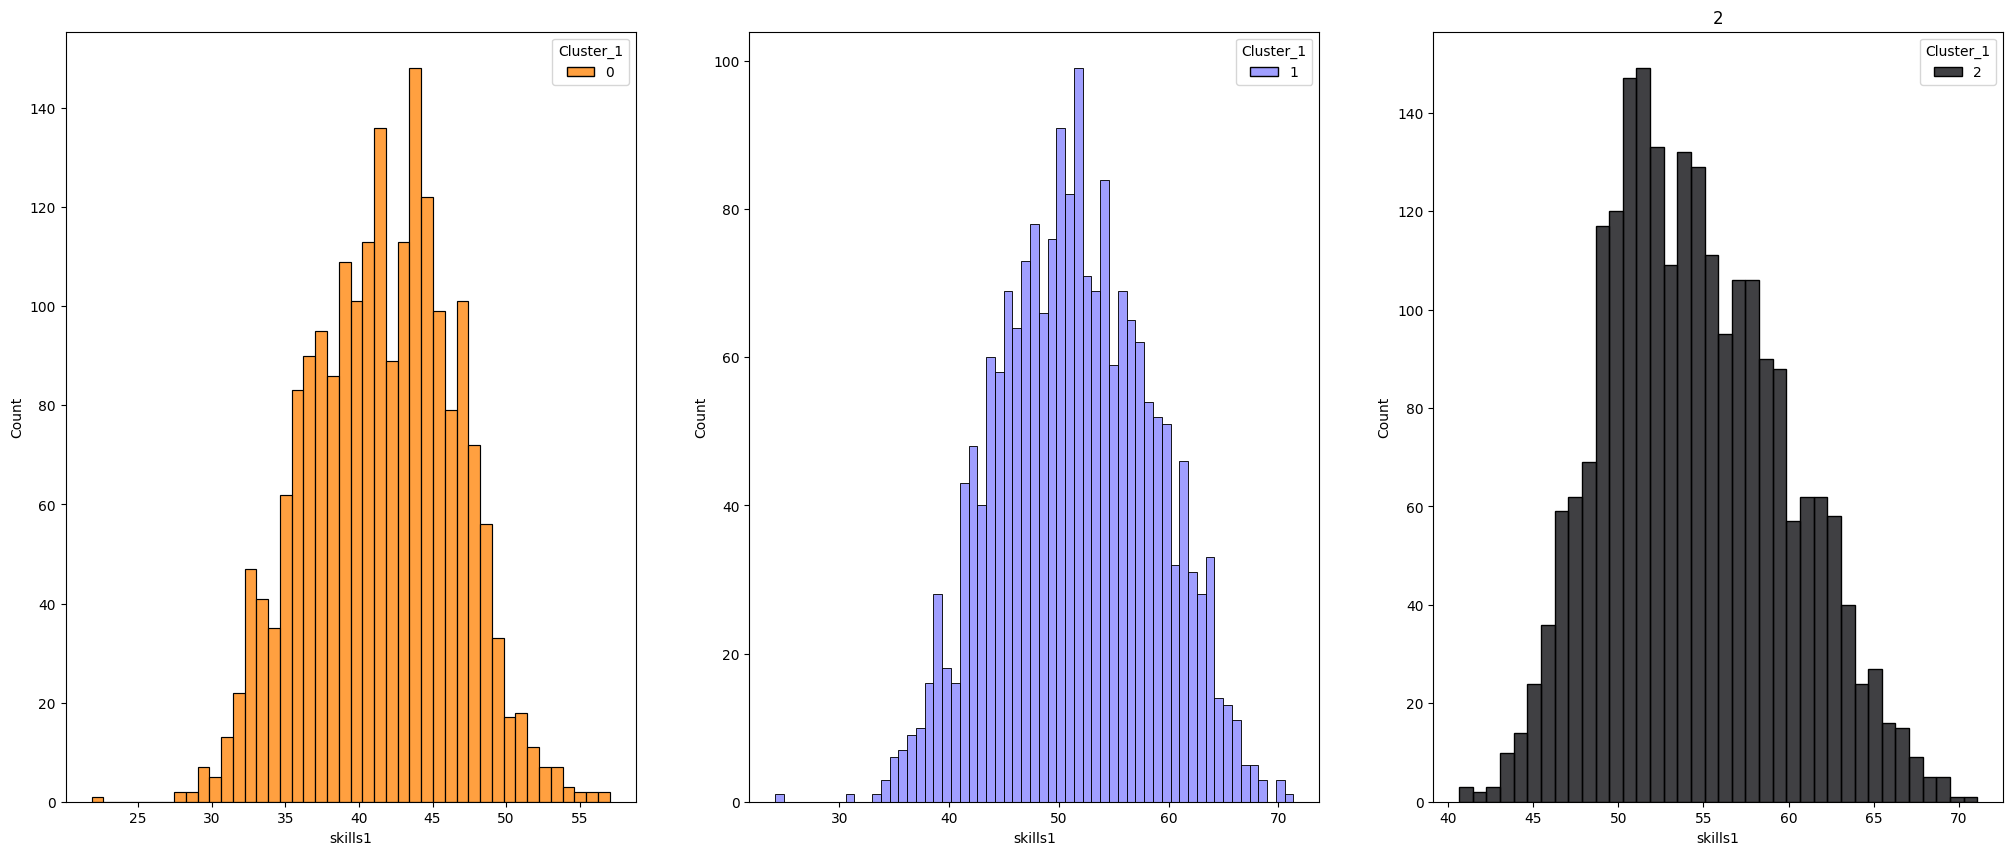

In [132]:
# Análisis de la skills1
temp_edad = df_final[['Cluster_1','skills1']]
fig,axs=plt.subplots(ncols=3,figsize =(25, 10))

for i in list(range(0,3)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='skills1',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

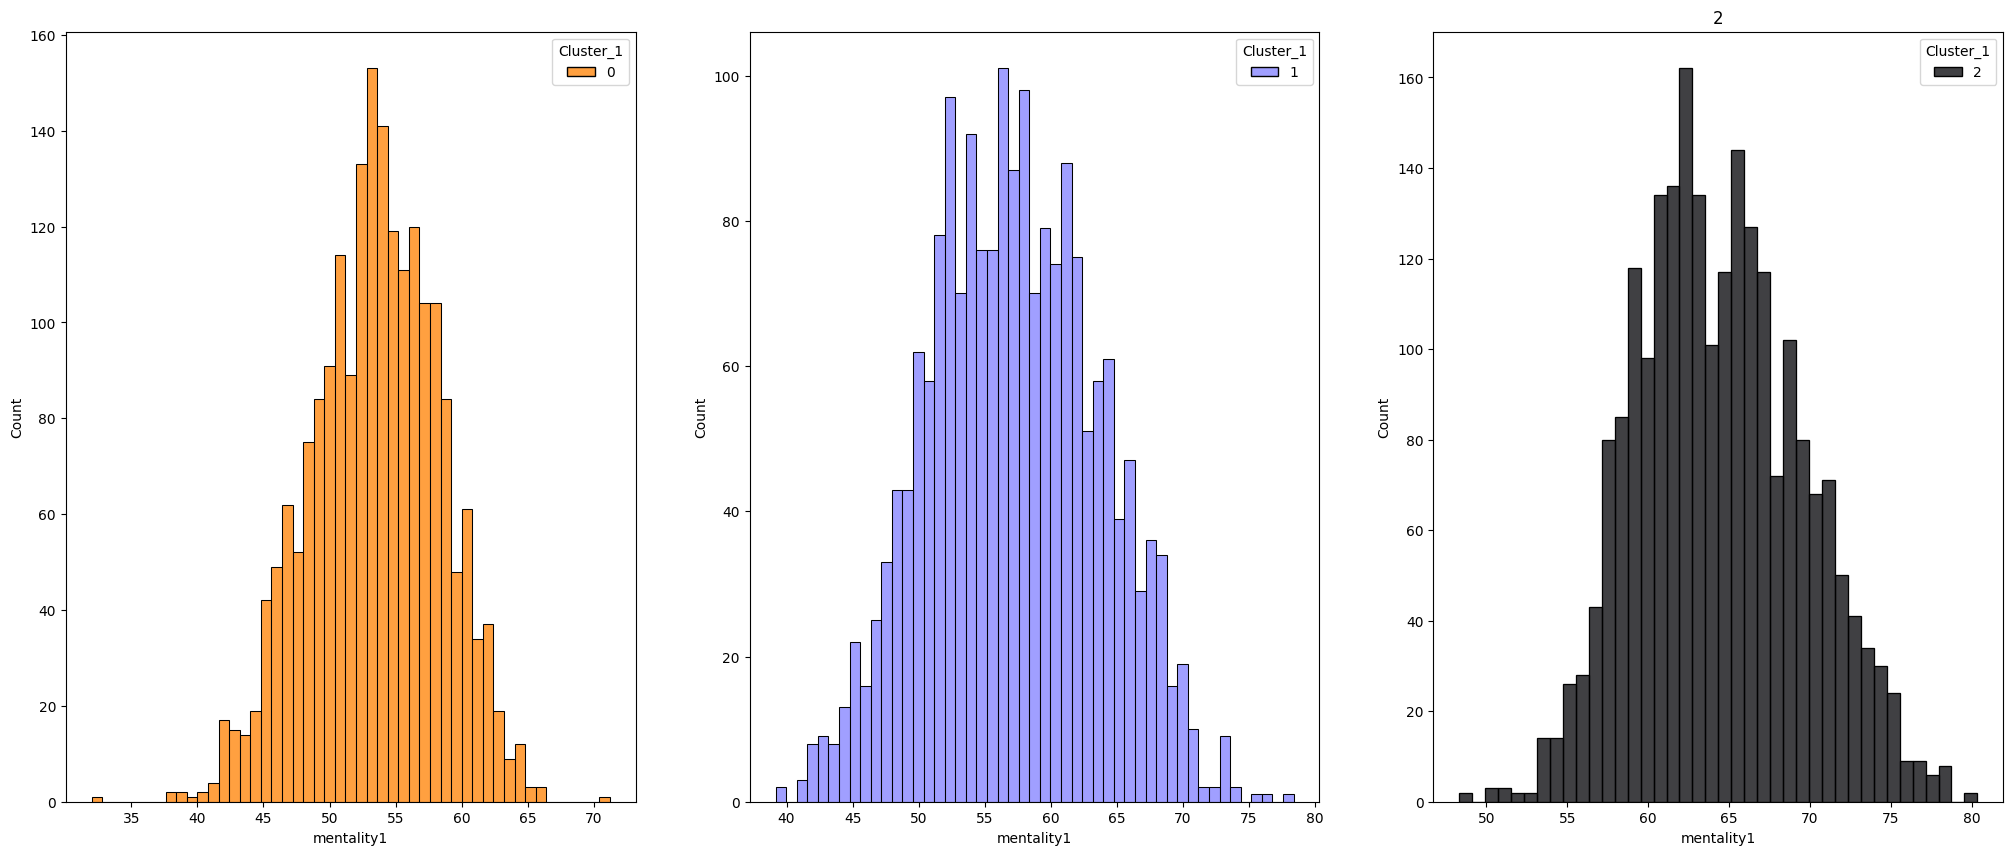

In [133]:
# Análisis de la mentality1
temp_edad = df_final[['Cluster_1','mentality1']]
fig,axs=plt.subplots(ncols=3,figsize =(25, 10))

for i in list(range(0,3)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='mentality1',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

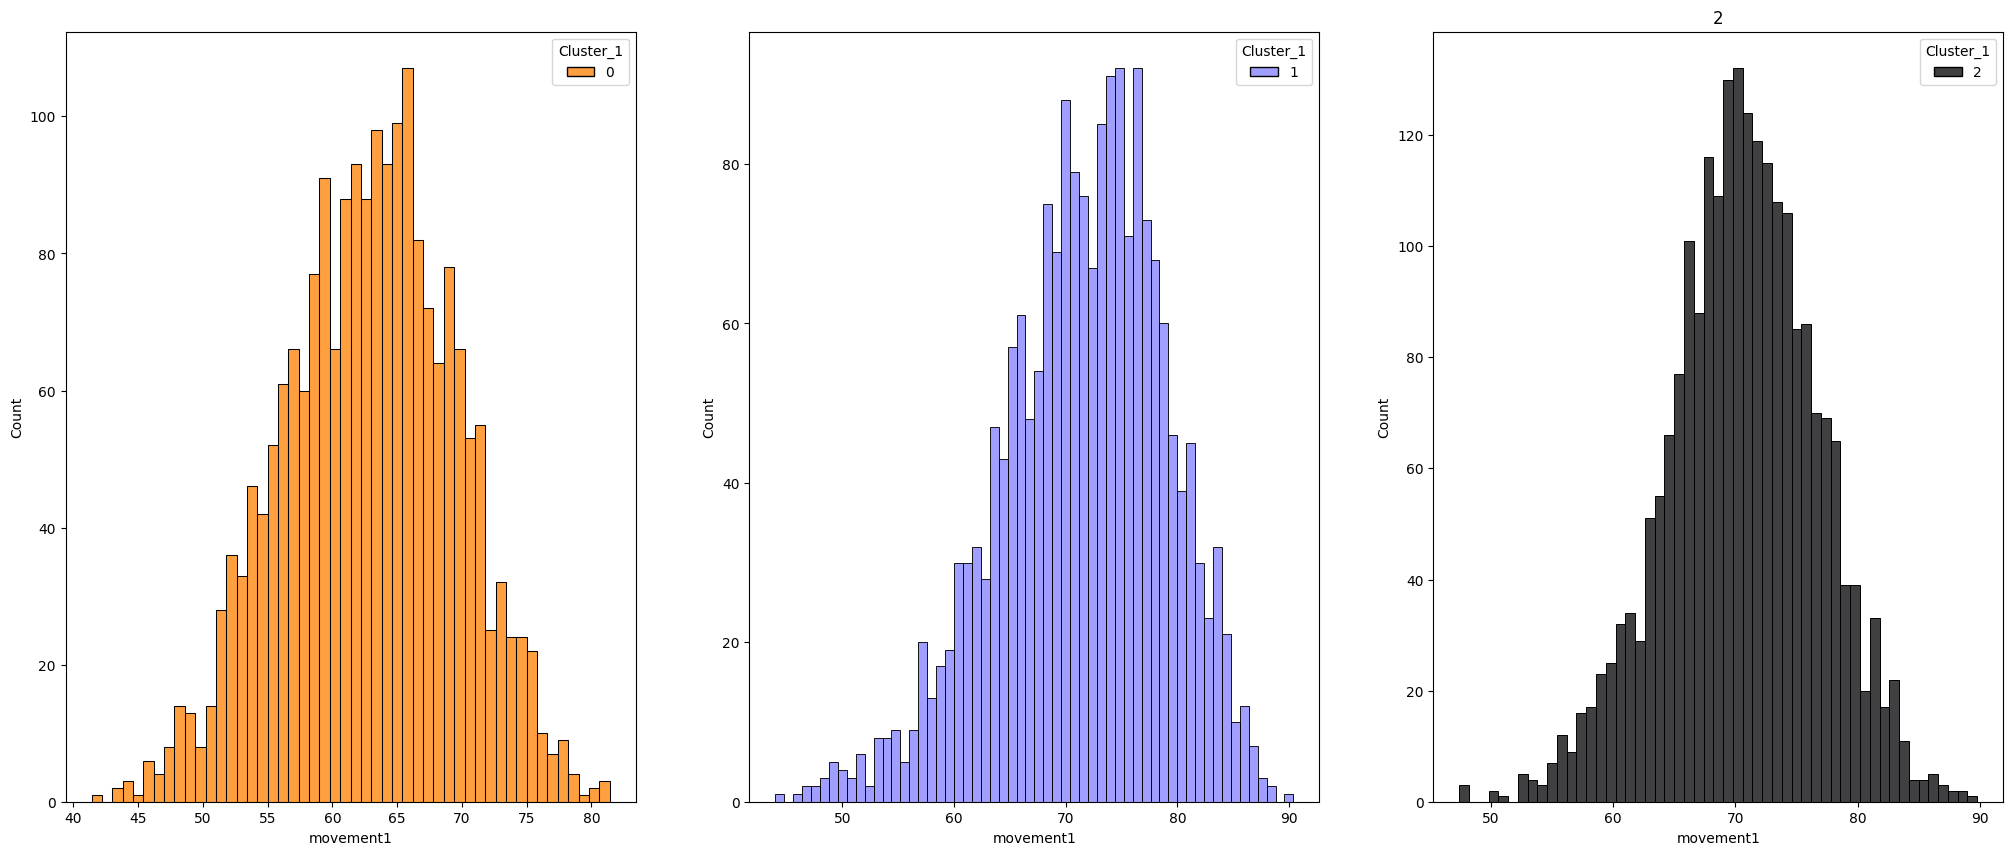

In [134]:
# Análisis de la movement1
temp_edad = df_final[['Cluster_1','movement1']]
fig,axs=plt.subplots(ncols=3,figsize =(25, 10))

for i in list(range(0,3)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='movement1',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

In [149]:
df_final[df_final['Cluster_1']==0]['club_position'].value_counts(normalize=True)

club_position
1    0.797637
0    0.198424
3    0.002462
2    0.001477
Name: proportion, dtype: float64

In [148]:
df_final[df_final['Cluster_2']==1]['club_position'].value_counts(normalize=True)

club_position
3    0.596154
0    0.393451
1    0.009875
2    0.000520
Name: proportion, dtype: float64

In [147]:
df_final[df_final['Cluster_3']==2]['club_position'].value_counts(normalize=True)

club_position
0    0.597512
1    0.369181
3    0.033307
Name: proportion, dtype: float64

In [119]:
df_final.head()

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,...,skills1,mentality1,movement1,power,Cluster_1,PCA1,PCA2,PCA3,Cluster_2,Cluster_3
0,83,32,177,77,3,80.0,82.0,78.0,84.0,31.0,...,65.666667,69.000000,81.4,73.0,1,60.885769,22.829899,4.621409,1,1
1,83,32,190,86,1,67.0,55.0,64.0,59.0,85.0,...,52.500000,63.833333,64.6,69.4,2,-35.543464,27.723571,11.204484,2,2
2,83,35,193,80,3,66.0,83.0,72.0,78.0,45.0,...,60.666667,70.833333,65.6,77.6,1,38.260896,24.187961,28.471847,1,1
3,83,31,178,77,1,66.0,55.0,76.0,72.0,84.0,...,58.833333,74.833333,71.6,71.6,2,-26.288109,45.156560,1.498547,2,2
4,83,32,183,80,0,72.0,81.0,77.0,81.0,80.0,...,64.333333,79.666667,76.6,85.6,2,-2.616748,64.646531,13.642067,2,2


**Cluster 0**
'club_position' 1 representa el 79.76% de las observaciones en el clúster 0.
'club_position' 0 representa el 19.84% de las observaciones en el clúster 0.
'club_position' 3 representa el 0.25% de las observaciones en el clúster 0.
'club_position' 2 representa el 0.15% de las observaciones en el clúster 0.

**Cluster 1**
'club_position' 3 representa el 59.62% de las observaciones en el clúster 1.
'club_position' 0 representa el 39.35% de las observaciones en el clúster 1.
'club_position' 1 representa el 0.99% de las observaciones en el clúster 1.
'club_position' 2 representa el 0.05% de las observaciones en el clúster 1.

**Cluster 2**
'club_position' 0 representa el 59.75% de las observaciones en el clúster 2.
'club_position' 1 representa el 36.92% de las observaciones en el clúster 2.
'club_position' 3 representa el 3.33% de las observaciones en el clúster 2.

Conclusión:

En el Clúster 0, la mayoría de las observaciones tienen la posición de club 1, con solo un pequeño porcentaje en otras posiciones.

En el Clúster 1, la posición de club 3 es la más común, seguida de la posición 0, con las otras dos posiciones siendo mucho menos comunes.

En el Clúster 2, las posiciones de club 0 y 1 son las más comunes, con una proporción significativamente menor de la posición 3.

De acuerdo a lo anterior se evidencia que los clústeres se formaron en función de las posiciones y que cada clúster tiene una distribución diferente de estas posiciones. Ya que nuestro objetivo es comprender cómo se agrupan los jugadores en función de sus posiciones en el club, esto ayudara a la toma de decisiones al momento de analizar un conjunto de jugadores.